In [1]:
#from main import SentimentAnalysis
import pandas as pd
import time

import spacy
sp = spacy.load("en_core_web_sm")
from textblob import TextBlob

from nltk.tag.stanford import StanfordPOSTagger as POS_Tag
import nltk
#nltk.download('vader_lexicon')
#nltk.download('brown')

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

from textblob import Word
stop_words = stopwords.words("english")
lemma = nltk.wordnet.WordNetLemmatizer()

2022-03-23 14:06:03.430425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 14:06:03.430462: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
home = r'./stanford-postagger-full'
#To tag using stanford pos tagger
nltk.download('punkt')

_path_to_model = home + '/models/english-bidirectional-distsim.tagger'
_path_to_jar = home + '/stanford-postagger.jar'

stanford_tag = POS_Tag(model_filename=_path_to_model, path_to_jar=_path_to_jar)

[nltk_data] Downloading package punkt to /home/sarthak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def posTag(review):
    return stanford_tag.tag(word_tokenize(review))

def getAspects(sen):
    rows = []
    aspect_tags = ["NN", "NNS", "NNP", "NNPS"]
    target = []
    tagged_sen = posTag(sen)
    for word, token in tagged_sen:
        if token in aspect_tags:
            target.append(word)
                
    return ", ".join([e for e in target])

# Extracting sentiments using sentence split and contrast word split.

In [4]:
# Run two times.
for _ in range(2):
    for i, e in enumerate(stop_words):
        if e[0]=="n":
            del stop_words[i]

In [5]:
for e in stop_words:
    if e[0]=="n":
        print(e)

In [6]:
contrast_words = ["on the contrary",
"yet",
"but",
"still",
"in comparison",
"rather",
"nor",
"conversely",
"at the same time",
"however",
"nevertheless",
"despite",
#"though",
"otherwise",
"by contrast",
#"instead",
"whereas",
"unlike",
"although",
"in contrast",
"notwithstanding",
"in spite of",
"alternatively",
"despite this",
"in contrast to",
"in contrast with"]

def getSentiments(reviewDf):
    sentences = []
    for row in reviewDf.iterrows():
        row = row[1]
        a = row["review_clean"].split(". ")
        for e in a:
            e = e.strip()
            if len(e.split(" "))<3:
                continue
            sentences.append(e)
    
    
    polarity = []
    subjectivity = []
    sens = []
    aspects = []
    #noAspects = []
    outDf = pd.DataFrame()
    
    for i, sen in enumerate(sentences):
        #row = row[1]
        flag = 0
        sen = sen.lower()
        for e in contrast_words:
            x = []
            if len(e.split(" "))==1:
                senList = sen.split(" ")
                if e in senList:
                    flag = 1
                    x = [" ".join([i for i in senList[:senList.index(e)]]), " ".join([i for i in senList[senList.index(e)+1:]])]
            
            else:
                if e in sen:
                    flag = 1
                    x = sen.split(e)

            for each in x:
                each = each.strip()
                if len(each.split(" "))<3:
                    continue
                
                # Performing Stop Word Removal.
                tokenizeSen = word_tokenize(each)
                stopSen = [wrd for wrd in tokenizeSen if not wrd.lower() in stop_words]
                    
                # Lemmatizing the sentence.
                lemSen = " ".join([lemma.lemmatize(wrd, "v") for wrd in stopSen])
                
                asp = getAspects(each)
                #if asp=='':
                #    noAspects.append(each)
                #    continue
                    
                aspects.append(asp)
                blob = TextBlob(lemSen)
                sentiment = blob.sentiment
                polarity.append(sentiment.polarity)
                subjectivity.append(sentiment.subjectivity)
                sens.append(each)

        if not flag:
            # Performing Stop Word Removal.
            tokenizeSen = word_tokenize(sen)
            stopSen = [wrd for wrd in tokenizeSen if not wrd.lower() in stop_words]
                    
            # Lemmatizing the sentence.
            lemSen = " ".join([lemma.lemmatize(wrd, "v") for wrd in stopSen])
            
            asp = getAspects(sen)
            #if asp=='':
            #    noAspects.append(sen)
            #    continue

            aspects.append(asp)
            blob = TextBlob(lemSen)
            #blob = blob.correct() # Spelling correction.
            sentiment = blob.sentiment
            polarity.append(sentiment.polarity)
            subjectivity.append(sentiment.subjectivity)
            sens.append(sen)
    
    outDf["sentence"] = sens
    outDf["polarity"] = polarity
    outDf["subjectivity"] = subjectivity
    outDf["aspects"] = aspects
    
    print(f"Length of collected data: {len(reviewDf)}")
    print(f"Length of final data: {len(outDf)}")
    
    return outDf

In [7]:
reviewDf = pd.read_csv("testReviewsEskilstuna.csv")

In [8]:
outDf = getSentiments(reviewDf)

Length of collected data: 590
Length of final data: 728


In [9]:
# outDf.to_csv("eskilstuna aspects sentiments.csv", index=None)
#outDf.to_csv("eskilstuna aspects sentiments_5.csv", index=None)
outDf.to_csv("eskilstuna aspects sentiments_stpWrd_5.csv", index=None)

In [182]:
# Using VADER Method.
sentences = []
for row in reviewDf.iterrows():
    row = row[1]
    a = row["review_clean"].split(". ")
    for e in a:
        e = e.strip()
        if len(e.split(" "))<3:
            continue
        sentences.append(e)
    
    #polarity = []
positive = []
negative = []
neutral = []
    #subjectivity = []
sens = []
aspects = []
noAspects = []
outDf = pd.DataFrame()
for i, sen in enumerate(sentences):
    #row = row[1]
    flag = 0
    sen = sen.lower()
    for e in contrast_words:
        x = []
        if len(e.split(" "))==1:
            senList = sen.split(" ")
            if e in senList:
                flag = 1
                x = [" ".join([i for i in senList[:senList.index(e)]]), " ".join([i for i in senList[senList.index(e)+1:]])]
            
        else:
            if e in sen:
                flag = 1
                x = sen.split(e)

        for each in x:
            each = each.strip()
            if len(each.split(" "))<3:
                continue
                
            asp = getAspects(each)
            if asp=='':
                noAspects.append(each)
                continue
                    
            aspects.append(asp)
                #sentiment = TextBlob(each).sentiment
                #polarity.append(sentiment.polarity)
                #subjectivity.append(sentiment.subjectivity)
            scores = sid.polarity_scores(each)
            positive.append(scores["pos"])
            negative.append(scores["neg"])
            neutral.append(scores["neu"])
            sens.append(each)

    if not flag:
        asp = getAspects(sen)
        if asp=='':
            noAspects.append(sen)
            continue

        aspects.append(asp)
        scores = sid.polarity_scores(sen)
        positive.append(scores["pos"])
        negative.append(scores["neg"])
        neutral.append(scores["neu"])
        sens.append(sen)
    
outDf["sentence"] = sens
outDf["positive"] = positive
outDf["negative"] = negative
outDf["neutral"] = neutral
outDf["aspects"] = aspects
    
print(f"Length of collected data: {len(reviewDf)}")
print(f"Length of final data: {len(outDf)}")

Length of collected data: 590
Length of final data: 643


In [184]:
outDf.to_csv("sentiment_eskilstuna_output_vader.csv", index=None)

# Testing the module

In [1]:
import time

[nltk_data] Downloading package punkt to /home/sarthak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loaded model utils...
Structuring Reviews...
Processing Reviews to remove noise...
Getting Sentiments...
Length of collected data: 114
Length of final data: 139


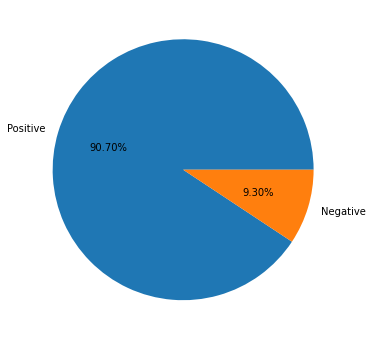

/home/sarthak/Code/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


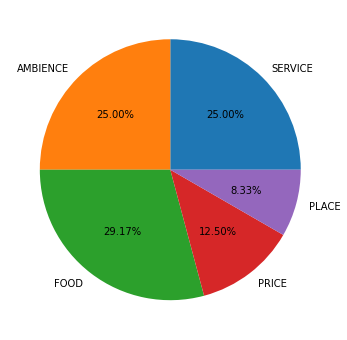

Total Time Taken: 4.34 mins


In [2]:
# Testing the module for ChopCHop Eskilstuna.
start = time.time()
url = "https://www.google.com/maps/place/ChopChop+Asian+Express/@59.3905008,16.4658164,15z/data=!4m5!3m4!1s0x0:0xb7f5c8a9d6cf8e01!8m2!3d59.390509!4d16.465848"
from main import get_aspect_reviews
obj = get_aspect_reviews(url, datetime=6)
obj.outDf.to_csv("eskilstuna_sentiments.csv", index=None)
stop = time.time()
print(f"Total Time Taken: {round((stop-start)/60, 2)} mins")

In [3]:
obj.aspCat

{'SERVICE': array(['order', 'king', 'guests', 'wait', 'time', 'call'], dtype=object),
 'AMBIENCE': array(['pace', 'opinion', 'disgust', 'edge', 'lot', 'think'], dtype=object),
 'FOOD': array(['pao', 'bowl', 'taste', 'food', 'peanuts', 'tofu', 'mix'],
       dtype=object),
 'PRICE': array(['bore', 'pay', 'mean'], dtype=object),
 'PLACE': array(['area', 'door'], dtype=object)}

Structuring Reviews...
Processing Reviews to remove noise...
Getting Sentiments...
Length of collected data: 247
Length of final data: 333


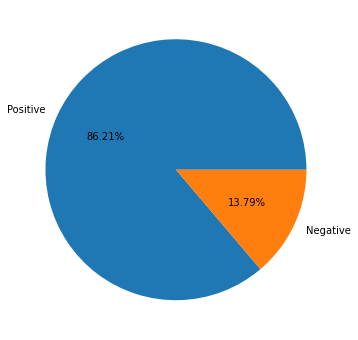

/home/sarthak/Code/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


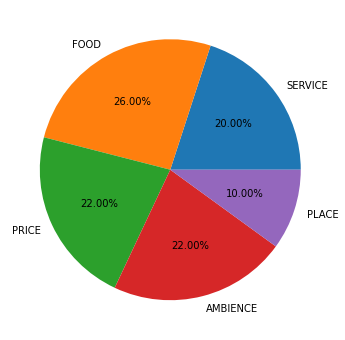

Total Time Taken: 11.91 mins


In [4]:
# Testing the module for ChopChop Eurostop.
start = time.time()
url = "https://www.google.com/maps/place/ChopChop+Eurostop/@59.2972832,15.2009381,15z/data=!4m5!3m4!1s0x0:0x9b177dc88b78bb49!8m2!3d59.2972832!4d15.2009381"
from main import get_aspect_reviews
obj = get_aspect_reviews(url, datetime=6)
obj.outDf.to_csv("eurostop_sentiments.csv", index=None)
stop = time.time()
print(f"Total Time Taken: {round((stop-start)/60, 2)} mins")

In [5]:
obj.aspCat

{'SERVICE': array(['selection', 'order', 'service', 'wait', 'staff', 'start', 'time',
        'kid', 'website', 'drive'], dtype=object),
 'FOOD': array(['rice', 'spice', 'chicken', 'vegetarians', 'chop', 'taste',
        'cashew', 'cashews', 'food', 'combo', 'lime', 'tofu', 'dish'],
       dtype=object),
 'PRICE': array(['receipt', 'price', 'portion', 'bore', 'face', 'problem', 'cash',
        'money', 'case', 'disappointment', 'send'], dtype=object),
 'AMBIENCE': array(['crowd', 'touch', 'shock', 'cold', 'smile', 'addition', 'screen',
        'piece', 'coziness', 'use', 'experience'], dtype=object),
 'PLACE': array(['restaurant', 'rest', 'friday', 'orange', 'base'], dtype=object)}

Structuring Reviews...
Processing Reviews to remove noise...
Getting Sentiments...
Length of collected data: 24
Length of final data: 47


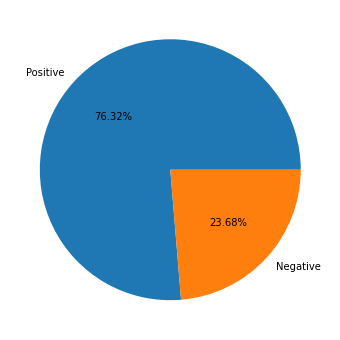

/home/sarthak/Code/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


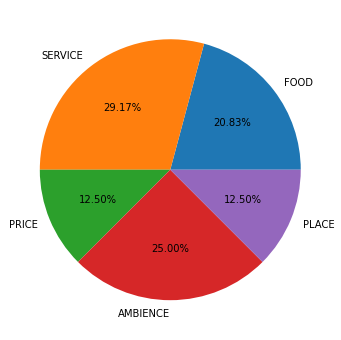

Total Time Taken: 1.39 mins


In [6]:
# Testing the module for Misora Sushi Vallentuna.
start = time.time()
url = "https://www.google.com/maps/place/Misora+Sushi+Vallentuna/@59.5350313,18.0784048,15z/data=!4m2!3m1!1s0x0:0xc175f7f85e0273c4?sa=X&ved=2ahUKEwjKgKvqpMz2AhWtlYsKHWZGDbgQ_BJ6BAgyEAU"
from main import get_aspect_reviews
obj = get_aspect_reviews(url, datetime=6)
obj.outDf.to_csv("misora_sushi_vallentuna_sentiments.csv", index=None)
stop = time.time()
print(f"Total Time Taken: {round((stop-start)/60, 2)} mins")

In [7]:
obj.aspCat

{'FOOD': array(['rice', 'sauce', 'bowl', 'salmon', 'food'], dtype=object),
 'SERVICE': array(['order', 'service', 'dishcloth', 'staff', 'time', 'tough', 'hand'],
       dtype=object),
 'PRICE': array(['price', 'response', 'torture'], dtype=object),
 'AMBIENCE': array(['dissatisfaction', 'today', 'smell', 'praise', 'criticism',
        'piece'], dtype=object),
 'PLACE': array(['second', 'place', 'hawaii'], dtype=object)}

Structuring Reviews...
Processing Reviews to remove noise...
Getting Sentiments...
Length of collected data: 152
Length of final data: 256


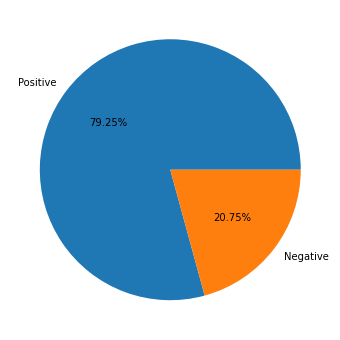

/home/sarthak/Code/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


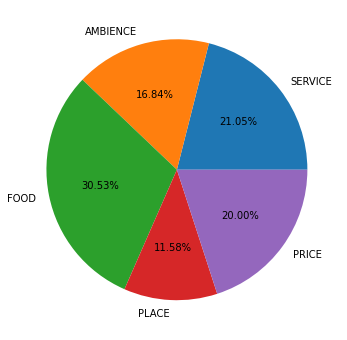

Total Time Taken: 7.12 mins


In [9]:
# Testing the module for Midan Odenplan.
start = time.time()
url = "https://www.google.com/maps/place/Midan/@59.343584,18.0531105,15z/data=!4m2!3m1!1s0x0:0xb13c5c95e3562ca7?sa=X&ved=2ahUKEwih--y8psz2AhV1IbcAHWAVCwQQ_BJ6BAgkEAU"
from main import get_aspect_reviews
obj = get_aspect_reviews(url, datetime=6)
obj.outDf.to_csv("midan_odenplan_sentiments.csv", index=None)
stop = time.time()
print(f"Total Time Taken: {round((stop-start)/60, 2)} mins")

In [10]:
obj.aspCat

{'SERVICE': array(['husband', 'service', 'sister', 'customers', 'contact', 'let',
        'season', 'name', 'guy', 'care', 'order', 'star', 'advice', 'time',
        'people', 'years', 'overcrowd', 'staff', 'go', 'court'],
       dtype=object),
 'AMBIENCE': array(['environment', 'scholars', 'attention', 'sweep', 'accord', 'music',
        'experience', 'turn', 'pity', 'quality', 'decor', 'cleanliness',
        'hygiene', 'rule', 'aspect', 'glass'], dtype=object),
 'FOOD': array(['drink', 'chickpeas', 'bread', 'regions', 'falafel', 'shawarma',
        'food', 'yogurt', 'kebab', 'meal', 'seed', 'cumin', 'paper',
        'pizza', 'potatoes', 'taste', 'sandwich', 'leftovers', 'plate',
        'tahini', 'kebabs', 'poison', 'lemon', 'sauce', 'meat',
        'pomegranate', 'tazo', 'pita', 'dish'], dtype=object),
 'PLACE': array(['table', 'plastic', 'days', 'crown', 'restaurant', 'date', 'base',
        'place', 'stockholm', 'one', 'floor'], dtype=object),
 'PRICE': array(['portion', 'rate', '

Structuring Reviews...
Processing Reviews to remove noise...
Getting Sentiments...
Length of collected data: 42
Length of final data: 68


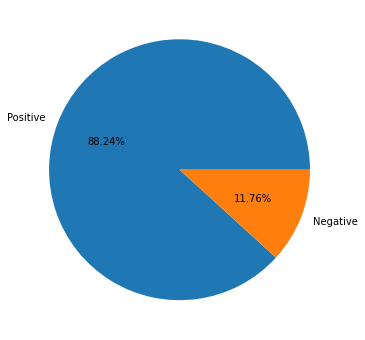

/home/sarthak/Code/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


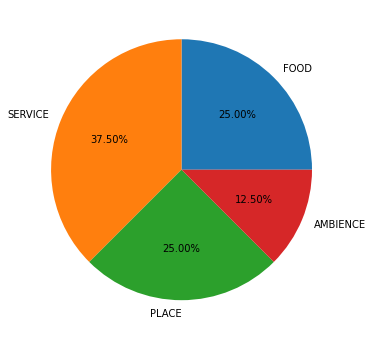

Total Time Taken: 1.94 mins


In [11]:
# Testing the module for Rockin Grill.
start = time.time()
url = "https://www.google.com/maps/place/Rockin+Grill/@59.3541114,18.0885143,15z/data=!4m2!3m1!1s0x0:0xb88b60769c513a1c?sa=X&ved=2ahUKEwi2uOy4p8z2AhXksosKHcqCBbkQ_BJ6BAgmEAU"
from main import get_aspect_reviews
obj = get_aspect_reviews(url, datetime=6)sp
obj.outDf.to_csv("rockin_grill_sentiments.csv", index=None)
stop = time.time()
print(f"Total Time Taken: {round((stop-start)/60, 2)} mins")

In [13]:
obj.aspCat

{'FOOD': array(['fry', 'food'], dtype=object),
 'SERVICE': array(['order', 'uber', 'staff'], dtype=object),
 'PLACE': array(['room', 'place'], dtype=object),
 'AMBIENCE': array(['addition'], dtype=object)}

# Extract word embeddings of aspects.

In [12]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
senDf = pd.read_csv("eurostop_sentiments.csv")
negRev = senDf[senDf["polarity"]<0]
negRev.dropna(inplace=True)
asp = []
for row in negRev.iterrows():
    row = row[1]
    asp.extend(row["aspects"].split(", "))
#aspects = set(negRev.aspects.values)
#aspects
asp = list(set(asp))

/home/sarthak/Code/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [37]:
noEmb = []
glove_embeddings = {}

with open('glove.6B/glove.6B.50d.txt', 'r') as fopen:
    for line in fopen:
        split_line = line.split()
        word = split_line[0]
        emb = np.array(split_line[1:], dtype=np.float64)
        glove_embeddings[word] = emb

word_embeddings = {}
for word in asp:
    if word in glove_embeddings.keys():
        word_embeddings[word] = glove_embeddings[word]    
    else:
        #continue
        noEmb.append(word)
        #word_embeddings[word] = (np.random.uniform(-0.25, 0.25, 50))

In [38]:
noEmb

['padthai', 'yakunikun', 'liite', 'chopchop']

In [39]:
wordEmbDf = pd.DataFrame({"word":word_embeddings.keys(), "embedding":word_embeddings.values()})
wordEmbMat = np.zeros((len(wordEmbDf), 50))
for i, row in enumerate(wordEmbDf.iterrows()):
    row = row[1]
    wordEmbMat[i] = row["embedding"]

In [40]:
from sklearn import preprocessing
X_norm = preprocessing.normalize(wordEmbMat)

In [ ]:
dists = []
rng = [e for e in range(2, 25)]
for i in rng:
    km = KMeans(n_clusters=i, init="k-means++", max_iter=300, random_state=0, n_init=10)
    km.fit(X_norm)
    dists.append(km.inertia_)

#y_km = km.fit_predict(wordEmbMat)

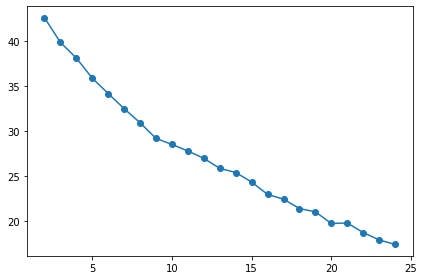

In [16]:
#plt.figure(figsize=(8,8))
plt.plot(rng, dists)
plt.scatter(rng, dists)
plt.tight_layout()
plt.show()

In [41]:
km = KMeans(n_clusters=6, init="k-means++", max_iter=300, random_state=42, n_init=25, copy_x=False)
y_km = km.fit_predict(X_norm)
print(f"Iterations: {km.n_iter_}")
print(f"Inertia: {km.inertia_}")

Iterations: 3
Inertia: 26.04035008210997


In [42]:
clusters = {}
for i in range(6):
    clusters[i] = []

for cl, row in zip(y_km, wordEmbDf.iterrows()):
    row = row[1]
    clusters[cl].append(row["word"])

In [43]:
from scipy.spatial.distance import euclidean

In [44]:
x = []
words = []
for cen in km.cluster_centers_:
    md = 200
    word = ""
    for i, e in enumerate(X_norm):
        if md > euclidean(e, cen):
            md = euclidean(e, cen)
            word = wordEmbDf.iloc[i]["word"]
            
    x.append(md)
    words.append(word)

In [58]:
clusters[3]

['times',
 'addition',
 'staff',
 'terminal',
 'base',
 'portions',
 'friday',
 'service',
 'portion',
 'website']

In [35]:
categories_midan = ["Place", "Money", "Customers", "Food", "Hygiene and Service"]

# Last category was also considered as food so merging that.
clusters[3].extend(clusters[4])

for e, cat in zip([0, 1, 2, 3, 5], categories_midan):
    print(f"{cat} | {round(len(clusters[e])/len(wordEmbDf.word)*100, 2)}%")
    print()

Place | 20.56%

Money | 11.21%

Customers | 16.82%

Food | 34.58%

Hygiene and Service | 16.82%



In [54]:
categories_eurostop = ["Experience", "Food", "Money", "Service"]

# Last category was also considered as food so merging that.
clusters[1].extend(clusters[4])
clusters[1].extend(clusters[5])

for e, cat in zip([0,1,2,3], categories_eurostop):
    print(f"{cat} | {round(len(clusters[e])/len(wordEmbDf.word)*100, 2)}%")
    print()

Experience | 41.38%

Food | 32.76%

Money | 8.62%

Service | 17.24%



In [57]:
np.savetxt("emb.tsv", wordEmbMat, delimiter=",")
wordEmbDf.word.to_csv("words.csv", index=None)

# Misc

# Extracting aspect word counts for negative reviews.

In [16]:
df = pd.read_csv("negative_reviews_eskilstuna.csv")
df.dropna(inplace=True)

In [17]:
aspectCntDict = {}
for row in df.iterrows():
    row = row[1]
    for each in row["aspects"].split(", "):
        if each not in aspectCntDict.keys():
            aspectCntDict[each] = 1
        else:
            aspectCntDict[each]+=1

In [ ]:
sorted(aspectCntDict.items(), key=lambda x: x[1], reverse=True)

In [25]:
nounPhraseDict = {}
for row in df.iterrows():
    row = row[1]
    noun_phrases = TextBlob(row["sentence"]).noun_phrases
    for e in noun_phrases:
        if e in nounPhraseDict.keys():
            nounPhraseDict[e]+=1
        else:
            nounPhraseDict[e] = 1

In [ ]:
sorted(nounPhraseDict.items(), key=lambda x: x[1], reverse=True)

## Using Spacy Method.

In [ ]:
ext_aspects = []

# Performing Aspect Extraction
aspSenDf = pd.DataFrame()
rows = []
for sen in obj.reviewDf["review_clean"]:
    important = sp(sen)
    descriptive_item = ''
    target = ''
    for token in important:
        if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
            target = token.text
        if token.pos_ == 'ADJ':
            added_terms = ''
            for mini_token in token.children:
                if mini_token.pos_ != 'ADV':
                    continue
                added_terms += mini_token.text + ' '
            descriptive_item = added_terms + token.text
                    
        if target!="" and descriptive_item!="":
            ext_aspects.append({'aspect': target,
                'description': descriptive_item})
        
            rows.append({"sentence":sen,'aspect': target,
                            'description': descriptive_item})

            target = ""
            descriptive_item = ""
        
aspSenDf = aspSenDf.append(rows, ignore_index=True)
sentiments = []
for desc in aspSenDf["description"]:
    sentiments.append(TextBlob(desc).sentiment)

aspSenDf["sentiment"] = sentiments

aspSenDf.to_csv("SentimentAnalysisResultsSpacyMethod.csv", index=None)

## Using Stanford method to get sentiment on description.

In [ ]:
ext_aspects = []

# Performing Aspect Extraction
aspSenDf = pd.DataFrame()
rows = []
aspect_tags = ["NN", "NNS", "NNP", "NNPS"]
description_tags = ['JJ','JJR','JJS']

for sen in obj.reviewDf["review_clean"]:
    descriptive_item = ''
    target = ''
    tagged_sen = posTag(sen)
    for word, token in tagged_sen:
        if token in aspect_tags:
            target = word
        
        if token in description_tags:
            descriptive_item = word
                    
        if target!="" and descriptive_item!="":
            ext_aspects.append({'aspect': target,
                'description': descriptive_item})
        
            rows.append({"sentence":sen,'aspect': target,
                            'description': descriptive_item})

            target = ""
            descriptive_item = ""
        
aspSenDf = aspSenDf.append(rows, ignore_index=True)

polarity = []
subjectivity = []
for desc in aspSenDf["description"]:
    sentiment = TextBlob(desc).sentiment
    polarity.append(sentiment[0])
    subjectivity.append(sentiment[1])


aspSenDf["polarity"] = polarity
aspSenDf["subjectivity"] = subjectivity
aspSenDf.to_csv("SentimentAnalysisResultsStanfordPOS_new.csv", index=None)

In [ ]:
## Using Class for Misora Sushi Vallentuna.
obj = SentimentAnalysis("Misora Sushi Vallentuna")
url = "https://www.google.com/maps/place/Misora+Sushi+Vallentuna/@59.5350313,18.0784048,15z/data=!4m2!3m1!1s0x0:0xc175f7f85e0273c4?sa=X&ved=2ahUKEwjhoeOb5MT2AhXBxosBHTYhAtkQ_BJ6BAgvEAU"
obj.collectData(url)
obj.processReviewDf()

# 38 0 polarity values
# 126 positive polarity values
# 33 negative polarity values

In [ ]:
# Extracting sentiments using word window.
for i, row in enumerate(aspSenDf.iterrows()):
    row = row[1]
    asp = row["aspect"]
    winInd = row["sentence"].index(asp)
    before, after = row["sentence"].split(asp)
    before, after = before.strip(), after.strip()
    before  = before.split(" ")[::-1][:min(4, len(before))][::-1]
    window = before + [asp] + after.split(" ")[:min(4, len(after))]
    window = " ".join([e for e in window])

In [9]:
# Selecting between stemmer or lemmatizer.
import nltk

lemma = nltk.wordnet.WordNetLemmatizer()
sno = nltk.stem.SnowballStemmer('english')
a = "without chop chop, there is no friday coziness"
" ".join([lemma.lemmatize(wrd, 'v') for wrd in word_tokenize(a)])
#sno.stem("")

'without chop chop , there is no friday coziness'

In [12]:
TextBlob("unfortunately badly clean in the premises and especially the toilet").sentiment

Sentiment(polarity=0.11111111111111112, subjectivity=0.5666666666666668)

In [ ]:
# Checking if we can work with noun phrases.
a = ["as fast food goes, it is really delicious eating!",
    "lots of guests during our visit and hence a little longer waiting time",
    "extra good with the orange chicken dish !!! 🤩 …",
    "good food, cold temperature inside",
    "a little taste poor food for and va asian",
    "large portions, recommend a combo with noodles, peanut chicken and spicy lime chicken! you are guaranteed to be full! …"]

for e in a:
    print(TextBlob(e).noun_phrases)
    print(TextBlob(e).tags)
    print()

# No, we can't.